<a href="https://colab.research.google.com/github/RenataTNT/ML_in_Production/blob/master/ML_in_biz_lesson4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.
Прочитайте базу COVID19_data.csv .

Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
covid_data=pd.read_csv('covid_19_data.csv')

In [0]:
COVID = covid_data.copy()

COVID['Date']= pd.to_datetime(COVID['ObservationDate']).dt.date

In [4]:
Russia=COVID.loc[COVID['Country/Region']=='Russia']
Russia_covid=Russia.set_index(pd.DatetimeIndex(Russia['Date'].values))
Russia_covid.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date
2020-04-14,14944,04/14/2020,NaN,Russia,2020-04-14 23:41:11,21102.0,170.0,1694.0,2020-04-14
2020-04-15,15264,04/15/2020,NaN,Russia,2020-04-15 23:04:26,24490.0,198.0,1986.0,2020-04-15
2020-04-16,15584,04/16/2020,NaN,Russia,2020-04-16 23:38:19,27938.0,232.0,2304.0,2020-04-16
2020-04-17,15904,04/17/2020,NaN,Russia,2020-04-17 23:38:48,32008.0,273.0,2590.0,2020-04-17
2020-04-18,16224,04/18/2020,NaN,Russia,2020-04-18 22:40:18,36793.0,313.0,3057.0,2020-04-18


In [5]:
Russia_covid=Russia_covid.groupby('Date').sum()
Russia_covid=Russia_covid.drop('SNo', axis=1)
Russia_covid.tail()

,Confirmed,Deaths,Recovered
Date,,,
2020-04-14,21102.0,170.0,1694.0
2020-04-15,24490.0,198.0,1986.0
2020-04-16,27938.0,232.0,2304.0
2020-04-17,32008.0,273.0,2590.0
2020-04-18,36793.0,313.0,3057.0


Будем анализировать не нарастающие итоги заболеваний, а дневные приросты

In [6]:
Russia_covid['Confirmed_daily']=Russia_covid['Confirmed']
Russia_covid['Confirmed_daily'].iloc[1:]=Russia_covid['Confirmed'].iloc[1:].values-Russia_covid['Confirmed'].iloc[:-1].values
Russia_covid

,Confirmed,Deaths,Recovered,Confirmed_daily
Date,,,,
2020-01-31,2.0,0.0,0.0,2.0
2020-02-01,2.0,0.0,0.0,0.0
2020-02-02,2.0,0.0,0.0,0.0
2020-02-03,2.0,0.0,0.0,0.0
2020-02-04,2.0,0.0,0.0,0.0
...,...,...,...,...
2020-04-14,21102.0,170.0,1694.0,2774.0
2020-04-15,24490.0,198.0,1986.0,3388.0
2020-04-16,27938.0,232.0,2304.0,3448.0


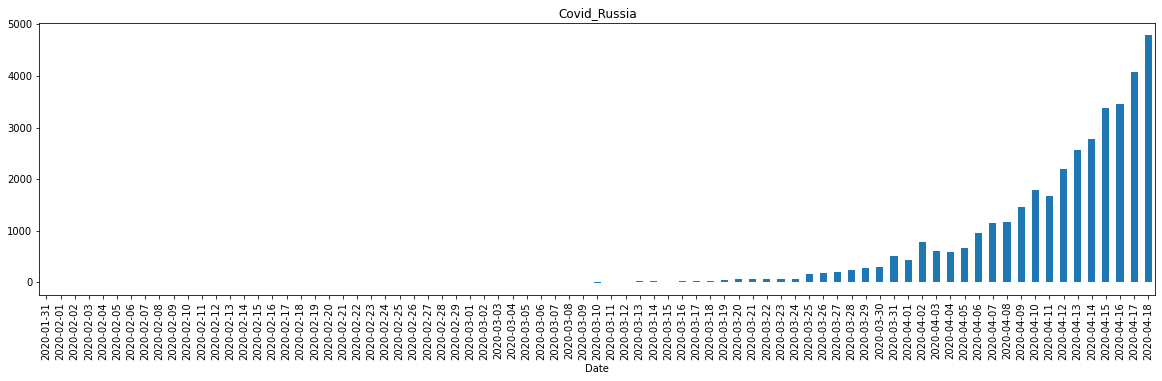

In [7]:
Russia_covid['Confirmed_daily'].plot(figsize=(20,5), title='Covid_Russia', kind='bar')

По опыту предудущего д/з возьмем диапаон данных когда стал наблюдаться увеличивающийся рост и применим boxcox преобразование

In [8]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


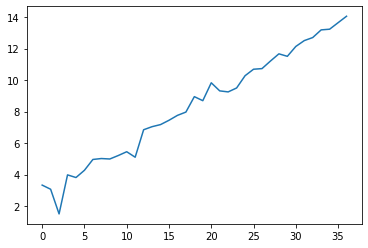

In [9]:
import scipy.stats as scs

X_dif_log, lmbda_dif = scs.boxcox(Russia_covid['Confirmed_daily'].values[42:])
plt.plot(X_dif_log)
plt.show()

In [10]:
X_dif_log

array([ 3.32865799,  3.06569339,  1.49849777,  3.97852505,  3.80989435,
        4.27094709,  4.95817497,  5.01678299,  4.9877248 ,  5.20775278,
        5.44923042,  5.10117394,  6.84571364,  7.04083844,  7.17333668,
        7.44712475,  7.75870425,  7.96835036,  8.94894514,  8.69215881,
        9.82856147,  9.31516955,  9.24998579,  9.50028198, 10.27889677,
       10.69043606, 10.729883  , 11.20961845, 11.66828383, 11.51073719,
       12.13703814, 12.50887764, 12.70323314, 13.1901538 , 13.23342068,
       13.64637164, 14.0567354 ])

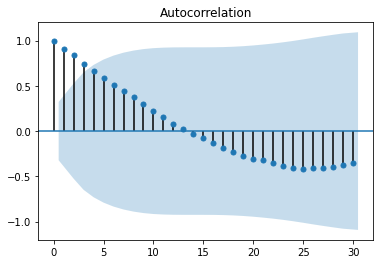

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


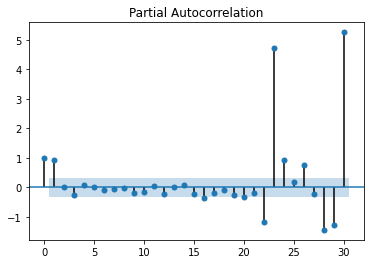

In [11]:
sm.graphics.tsa.plot_acf(X_dif_log, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(X_dif_log, lags=30)
plt.show()

p=3, q=1

In [12]:
import warnings
# Определим p, d и q 
q = 1
p = 3
d = 0
pdq = [p, d, q]


warnings.filterwarnings("ignore") # отключает предупреждения

# отнесм в тестовую выборку 5 последних измерений, на остальных будем тренировать модель
mod1 = sm.tsa.statespace.SARIMAX(X_dif_log[:-5],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results_cov_log = mod1.fit()
print('ARIMA{} - AIC:{}'.format(pdq, results_cov_log.aic))

print(results_cov_log.summary().tables[0],results_cov_log.summary().tables[1])

ARIMA[3, 0, 1] - AIC:33.2920534599758
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(3, 0, 1)   Log Likelihood                  -9.646
Date:                Mon, 20 Apr 2020   AIC                             33.292
Time:                        20:06:51   BIC                             42.863
Sample:                             0   HQIC                            36.290
                                 - 32                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     

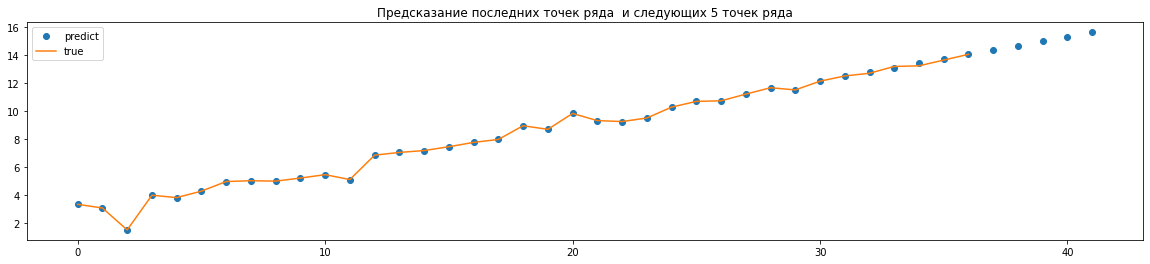

In [13]:
plt.figure(figsize=(20,4))

pred_dynamic_log = results_cov_log.forecast(10)    #делаем предсказание на 10 точки от текущего конца ряда

plt.plot(list(X_dif_log[:-5])+list(pred_dynamic_log),'o', label='predict')
#Отобразим истинный значения 
plt.plot(X_dif_log,label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [0]:
import numpy as np

def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Обратное предобазование

In [15]:
pred_log_inv=invboxcox(pred_dynamic_log,lmbda_dif)
pred_log_inv

array([2882.20697095, 3264.6364785 , 3714.10186063, 4216.10390889,
       4776.46021318, 5401.39077981, 6098.26565637, 6873.963534  ,
       7736.21067746, 8693.30220047])

In [16]:
Russia_covid.index[78]

datetime.date(2020, 4, 18)

In [17]:
datelist = pd.date_range(Russia_covid.index[78], periods=6).date.tolist()
datelist[1:]

[datetime.date(2020, 4, 19),
 datetime.date(2020, 4, 20),
 datetime.date(2020, 4, 21),
 datetime.date(2020, 4, 22),
 datetime.date(2020, 4, 23)]

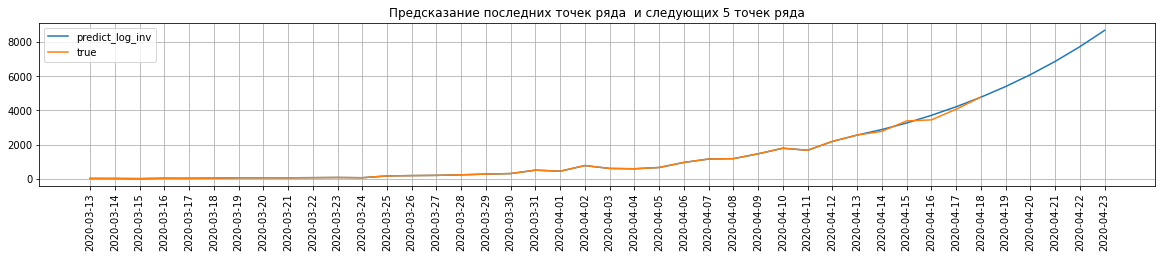

In [18]:
plt.figure(figsize=(20,3))


plt.plot(list(Russia_covid.index[42:])+datelist[1:], list(Russia_covid['Confirmed_daily'].values[42:-5])+list(pred_log_inv), label='predict_log_inv')
#Отобразим истинный значения 
plt.plot(list(Russia_covid.index[42:]),Russia_covid['Confirmed_daily'].values[42:],label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')

plt.xticks(list(Russia_covid.index[42:])+datelist[1:],rotation='vertical')
plt.grid()

plt.legend()
plt.plot()
plt.show()

In [19]:
from sklearn.metrics import r2_score
r2_score(Russia_covid['Confirmed_daily'].values[-5:],pred_log_inv[:5])

0.9489080769165839

Отступим h=4 от начала теста (тест = 5 последних значений ряда) и ограничим этой датой треннировочные данные:

In [20]:
h=4
mod4 = sm.tsa.statespace.SARIMAX(X_dif_log[:(-5-h)],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results_cov_log2 = mod4.fit()
print('ARIMA{} - AIC:{}'.format(pdq, results_cov_log2.aic))

ARIMA[3, 0, 1] - AIC:33.23077835800173


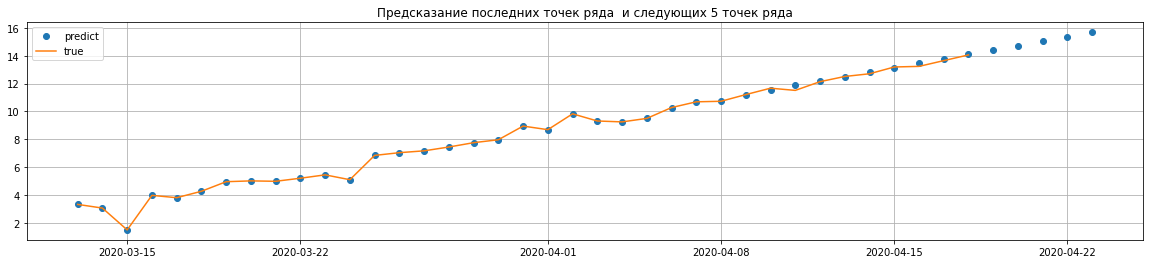

In [21]:
plt.figure(figsize=(20,4))

pred_dynamic_log2 = results_cov_log2.forecast(10+h)    #делаем предсказание на 10+h точки от текущего конца ряда

plt.plot(list(Russia_covid.index[42:])+datelist[1:],list(X_dif_log[:-5-h])+list(pred_dynamic_log2),'o', label='predict')
#Отобразим истинный значения 
plt.plot(list(Russia_covid.index[42:]),X_dif_log,label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.grid()
plt.show()

In [22]:
pred_log_inv2=invboxcox(pred_dynamic_log2,lmbda_dif)
pred_log_inv2

array([1696.36084271, 1949.19321911, 2227.60313942, 2548.72009329,
       2909.52235432, 3315.49327977, 3770.54917477, 4280.48203803,
       4850.78360131, 5487.71098512, 6197.92630657, 6988.73088714,
       7868.00925628, 8844.31240106])

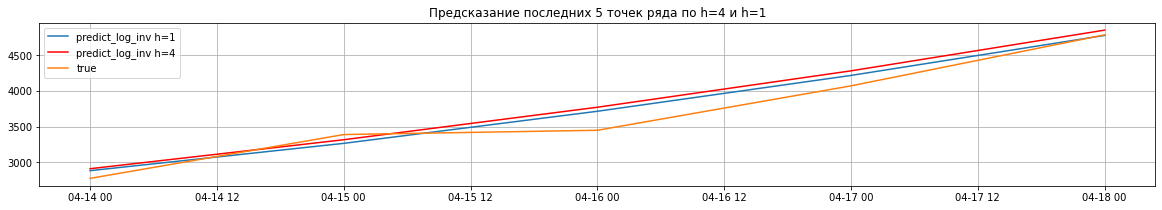

In [23]:
plt.figure(figsize=(20,3))

plt.plot(Russia_covid.index[-5:],pred_log_inv[:-5], label='predict_log_inv h=1')
plt.plot(Russia_covid.index[-5:],pred_log_inv2[h:-5],label='predict_log_inv h=4' , color='red')
#Отобразим истинный значения 
plt.plot(Russia_covid.index[-5:], Russia_covid['Confirmed_daily'].values[-5:],label='true')
plt.title('Предсказание последних 5 точек ряда по h=4 и h=1')
plt.legend()
plt.grid(which='both')
plt.show()

In [24]:
#Last 5 true
last_5_true=Russia_covid['Confirmed_daily'].values[-5:]
last_5_true

array([2774., 3388., 3448., 4070., 4785.])

In [25]:
#Last 5 h=1
last_5_h1=pred_log_inv[:-5]
last_5_h1

array([2882.20697095, 3264.6364785 , 3714.10186063, 4216.10390889,
       4776.46021318])

In [26]:
#Last 5 h=4
last_5_h4=pred_log_inv2[h:-5]
last_5_h4

array([2909.52235432, 3315.49327977, 3770.54917477, 4280.48203803,
       4850.78360131])

In [27]:
r2_score(last_5_true,last_5_h1)

0.9489080769165839

In [28]:
r2_score(last_5_true,last_5_h4)

0.9244098399289304

Видно, что чем дальше треннировочные данные от предсказываемого диапазона, тем ниже качество прогноза

2. Примените авторекурсию и сравните результат путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 10-ти точек.

In [0]:
def train_model(X):
  mod = sm.tsa.statespace.SARIMAX(X,
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
  results = mod.fit()
  return results

In [30]:
h=10
X_test = X_dif_log[-h:].copy()
print('boxcox от реальных', h, 'последних элементов',X_test)

X_train = X_dif_log[:-h].copy()

y_test_direct=train_model(X_train).forecast(10)
print('их предсказание прямой моделью', y_test_direct)





boxcox от реальных 10 последних элементов [11.20961845 11.66828383 11.51073719 12.13703814 12.50887764 12.70323314
 13.1901538  13.23342068 13.64637164 14.0567354 ]
их предсказание прямой моделью [11.2006632  11.53851547 11.86353366 12.17624532 12.49469248 12.8122068
 13.13034856 13.44819628 13.76613633 14.08403613]


In [0]:
y_test=y_test_direct.copy()
X_train_new=X_train.copy()
for i in range(h):
  y_test[i]=train_model(X_train_new).forecast(1)
   # заполняем вектор для прогноза следующей точки
  X_train_new=np.append(X_train_new,y_test[i])
  

In [33]:
# предсказание рекурсивной моделью 10 последних точек
y_test

array([11.2006632 , 11.54817246, 11.86580084, 12.17783542, 12.50049059,
       12.81458222, 13.13280794, 13.45593879, 13.76983078, 14.08861931])

In [34]:
#Обратное преобразование
last_10_direct=invboxcox(y_test_direct,lmbda_dif)
print(last_10_direct)
last_10_rec=invboxcox(y_test,lmbda_dif)
print(last_10_rec)

[1453.18455259 1687.45514486 1943.92240889 2222.81281557 2542.83735056
 2902.07469683 3306.59429907 3760.05135475 4268.13821839 4836.30407521]
[1453.18455259 1694.61837829 1945.826814   2224.31737604 2549.02531907
 2904.92407013 3309.90735146 3771.75487749 4274.38432992 4844.96466003]


In [35]:
last_10_true=Russia_covid['Confirmed_daily'][-h:].values
last_10_true


array([1459., 1786., 1667., 2186., 2558., 2774., 3388., 3448., 4070.,
       4785.])

In [36]:
# r2 при прямом прогнозе 5 точек
r2_score(last_10_true,last_10_direct)

0.9769587992613178

In [0]:
# r2 при рекурсивном прогнозе каждой следующей из 10-ти точек

In [38]:
r2_score(last_10_true,last_10_rec)

0.9759655710286801

Качество по r2 при рекурсивном подходе в нашем случае,несущественно, но снизилось :)

3. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й точки

In [0]:
def MAPE(y_true, y_pred):
  return np.mean(abs(1-y_pred/y_true))*100

In [40]:
MAPE(np.array(last_10_true),np.array(last_10_rec))

4.70343217657531

In [41]:
err_direct=[]
for i in range(h):
  err_direct.append(MAPE(np.array(last_10_true[:i+1]),np.array(last_10_direct[:i+1])))
print(err_direct)

[0.39859132323724067, 2.9581101953031985, 7.509414173281326, 6.053067212453028, 4.961004586510807, 4.903665182539516, 4.546393823730834, 5.1093712588655515, 5.0825812183413195, 4.681541644480584]


In [42]:
err_rec=[]
for i in range(h):
  err_rec.append(MAPE(np.array(last_10_true[:i+1]),np.array(last_10_rec[:i+1])))
print(err_rec)

[0.39859132323724067, 2.757571745398085, 7.41380235944213, 5.998565127809511, 4.869021616971412, 4.8441322302482215, 4.481395885899638, 5.09492672748583, 5.086793536430004, 4.70343217657531]


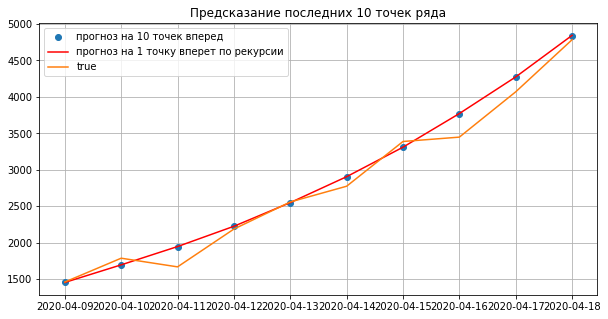

In [43]:
plt.figure(figsize=(10,5))

plt.plot(Russia_covid.index[-h:],last_10_direct, 'o', label='прогноз на 10 точек вперед')
plt.plot(Russia_covid.index[-h:],last_10_rec,label='прогноз на 1 точку вперет по рекурсии' , color='red')
#Отобразим истинный значения 
plt.plot(Russia_covid.index[-h:], Russia_covid['Confirmed_daily'].values[-h:],label='true')
plt.title('Предсказание последних 10 точек ряда')
plt.legend()
plt.grid()
plt.show()

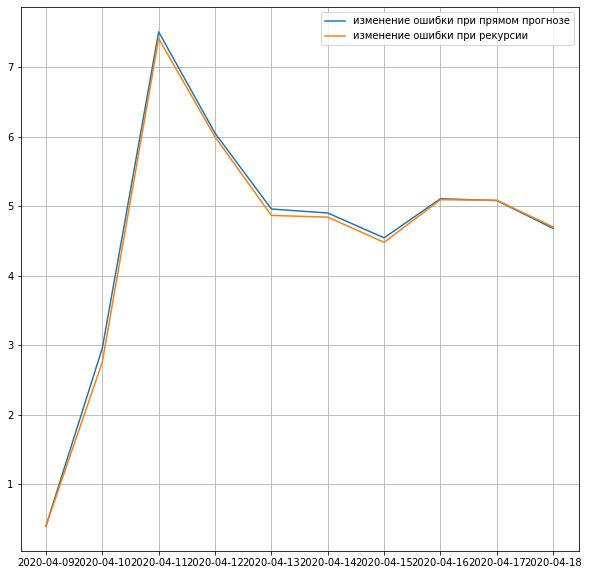

In [44]:
plt.figure(figsize=(10,10))
plt.plot(Russia_covid.index[-h:],err_direct, label='изменение ошибки при прямом прогнозе')
plt.plot(Russia_covid.index[-h:],err_rec, label='изменение ошибки при рекурсии')
plt.legend()

plt.grid()
plt.show()

Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Видно, что по MAPE рекурсивный подход был лучше прямого до 8-го предсказания, а после 9-го и 10-го обобщенный MAPE стал чуть хуже